# Multilable text classification with fastai v2

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.text.all import *

In [3]:
import fastai
fastai.__version__

'2.6.3'

In [4]:
path = Path('.')

## Prepare dataframe

In [51]:
df_trn = pd.read_csv(path/'data'/'train_Robinson.csv', skiprows=1,low_memory=False, dtype={'Contributing Factors / Situations':str})
df_val = pd.read_csv(path/'data'/'valid.csv', skiprows=1,low_memory=False, dtype={'Contributing Factors / Situations':str})
df_trn['is_valid'] = False
df_val['is_valid'] = True
df_trn[['Contributing Factors / Situations', 'Narrative']].head(5)

,Contributing Factors / Situations,Narrative
0,Aircraft; Equipment / Tooling; Human Factors,[I was] working air carrier 1 at FL190. Sector 68 called for a point out of air carrier 2. Aircraft 2 was assigned FL170. [I] referenced air carrier 1 traffic; approved the point out. When I saw [that] aircraft 2 was climbing [I] gave [the] traffic call and took corrective action to re-establish standard separation by turning air carrier 1 to a 360 degree heading. When separation was established [I] routed the air carrier 1 back [on route].
1,Human Factors,Aircraft X; a CRJ2; landed Runway XXL and was instructed to 'turn left and contact ground point 8'. He exited; but did not entirely clear the runway. He informed Ground Control that he had a steering issue and was having problems exiting. We had no arrivals for about 25 miles and none were lined up on final yet and no departures ready to depart. Aircraft X informed me that he was trying to exit and I informed him to switch over to Ground Control and that we were aware of his situation. I then informed my Supervisor of his problem. She called Airport Operations and they closed the run...
2,Human Factors; Procedure; Staffing,I was working combined sectors with no D-side. The weather was not bad but there was continuous light chop at all of my altitudes. Aircraft X checked on and; as soon as he crossed into my sector on the LLEEO STAR; I issued him pilot discretion to FL240. When he approached the low sector that was combined with the high sector I told [the] aircraft to descend now maintain FL200 to keep him above some CLE departure traffic. Once the traffic was no factor I issued the pilot a clearance to cross LLEEO at and maintain FL100.I went about other duties and when the aircraft was approximately 12-15 ...
3,Procedure; Human Factors; Aircraft; Staffing; Weather,[We] arrived to a cold airplane with ambient temperatures around -10 degrees Celsius. I noticed the flight departing thirty minutes after ours was connected to ground heater cart. Due to a delayed departure time; to accommodate rest; we were asked to commence boarding immediately by Operations. I started the APU to start warming the aircraft. Fueling of the aircraft was not completed until after boarding was accomplished. During engine start flow the left fuel pump would not come on line on the first press of the button. I reselected the switch and it eventually came on line. Attempted to ...
4,Aircraft; Weather,During the climbout we entered the ragged overcast between 12;000 and 14;000. At 18;000 FT we adjusted all barometric settings to 29.92. Passing through FL190 while cleared to climb to final cruise altitude of FL340; the ambient weather conditions indicated icing conditions existed and we turned on all engine anti-ice and airfoil anti-ice. (Note: The Air Data Heat switch had been on since before conducting the 'Before Engine Start' checklist back at the gate). No ice accumulation was noted throughout the climb; or anytime during the event. The FMS indicated that we were able to climb to a ...


In [6]:
df_trn.shape, df_val.shape

((4500, 98), (2948, 98))

In [7]:
df_trn.dropna(axis=0, subset=['Contributing Factors / Situations'], inplace=True)
df_val.dropna(axis=0, subset=['Contributing Factors / Situations'], inplace=True)

In [8]:
len(df_trn), len(df_val)

(4485, 2935)

## Language model

Fine tune the language model

In [9]:
df = pd.concat([df_trn, df_val], ignore_index=True)

In [10]:
bs = 96

In [11]:
dls_db = DataBlock(blocks=TextBlock.from_df('Narrative', is_lm=True), 
                   get_x=ColReader('text'), # should be 'text'!!!
                   splitter=RandomSplitter(0.1)) #

In [12]:
dls_lm = dls_db.dataloaders(df, bs=bs)

In [13]:
dls_lm.show_batch(max_n=3)

/home/krasin/mambaforge/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/krasin/mambaforge/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/krasin/mambaforge/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/krasin/mambaforge/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({labe

,text,text_
0,xxbos xxmaj upon approach the flaps failed to come down so we were forced to abandon the approach . xxmaj we ran the emergency non / normal procedure and tried to trouble shoot the problem . xxmaj approach gave us headings and altitudes away from the airport after the captain declared an emergency . xxmaj we notified dispatch and all the appropriate channels of our situation . xxmaj after we were satisfied,xxmaj upon approach the flaps failed to come down so we were forced to abandon the approach . xxmaj we ran the emergency non / normal procedure and tried to trouble shoot the problem . xxmaj approach gave us headings and altitudes away from the airport after the captain declared an emergency . xxmaj we notified dispatch and all the appropriate channels of our situation . xxmaj after we were satisfied with
1,off that duct for any reason ( i believe it may have been because it was a -300 series aircraft and the xxmaj air xxmaj conditioning xxmaj system is different than a xxunk series ) . i was unfamiliar that it even had cannon plugs attached . xxmaj and the fact of reconnecting the cannon plugs was not in my thoughts whatsoever ; even after the installation . xxmaj the cannon plugs,that duct for any reason ( i believe it may have been because it was a -300 series aircraft and the xxmaj air xxmaj conditioning xxmaj system is different than a xxunk series ) . i was unfamiliar that it even had cannon plugs attached . xxmaj and the fact of reconnecting the cannon plugs was not in my thoughts whatsoever ; even after the installation . xxmaj the cannon plugs were
2,to xxrep 3 z a xxmaj logbook entry was made that all the water in the tank was depleted . xxmaj prior to our later dispatch on xxrep 3 z - xxrep 4 z ; later that day ; the xxmaj potable xxmaj water xxmaj quantity xxmaj gage was placed on xxup mel . xxmaj due to the nature of the xxmaj logbook write - up ; it would have been prudent,xxrep 3 z a xxmaj logbook entry was made that all the water in the tank was depleted . xxmaj prior to our later dispatch on xxrep 3 z - xxrep 4 z ; later that day ; the xxmaj potable xxmaj water xxmaj quantity xxmaj gage was placed on xxup mel . xxmaj due to the nature of the xxmaj logbook write - up ; it would have been prudent to


In [14]:
# dls_lm.save('tmp_lm')

In [15]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

In [16]:
# learn_lm.lr_find()
# #learn_lm.recorder.plot(skip_end=10)

In [17]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.935159,3.625052,0.320212,37.526691,02:09


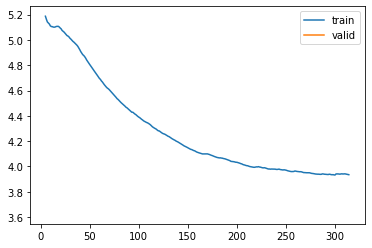

In [18]:
learn_lm.recorder.plot_loss()

In [19]:
learn_lm.save('fit_head')

Path('models/fit_head.pth')

In [20]:
learn_lm.load('fit_head')

In [21]:
# learn_lm.unfreeze()
# learn_lm.fit_one_cycle(5, 1e-3)

In [22]:
learn_lm.save('fine_tuned')

Path('models/fine_tuned.pth')

In [23]:
learn_lm.save_encoder('fine_tuned_enc')

Fine tuned models *fit_head*, *fine_tuned* and *fine_tuned_enc* are saved in default `path/models` folder

## Classifier

In [24]:
bs = 48

In [25]:
dls_db_clas = DataBlock(blocks=(TextBlock.from_df('Narrative', seq_len=72, vocab=dls_lm.vocab), MultiCategoryBlock()),
                      get_x=ColReader('text'),
                      get_y=ColReader('Contributing Factors / Situations', label_delim='; '),
                      splitter=IndexSplitter(range(len(df_trn), len(df)))) #splitter=ColSplitter(col='is_valid')

In [26]:
dls_clas = dls_db_clas.dataloaders(df, bs=bs)

In [27]:
dls_clas.show_batch(max_n=3)

/home/krasin/mambaforge/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/krasin/mambaforge/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/krasin/mambaforge/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/home/krasin/mambaforge/lib/python3.9/site-packages/fastai/torch_core.py:476: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({labe

,text,None
0,xxbos xxmaj while northbound on taxiway xxup s ; i was cleared to xxmaj runway xxup xxl via xxup s ; xxup d ; xxup d10 ; xxup e. xxmaj the north half of xxrep 3 z seemed nearly xxunk of taxiing aircraft . xxmaj on xxup s ; i could see no one ahead of me or approaching from behind on d or xxup e. xxmaj as i turned onto d from s my path along d and e looked like it would be clear all the way to xxup xxl . xxmaj anything i saw looked far away from me . xxmaj the portion of e that i could see ahead of the xxup q400 left wing tip remained clear as i taxied east on xxup d. i turned onto xxup d10 and as the aircraft rotated so that i could see what was behind me past the,Company Policy;Human Factors
1,xxbos xxmaj it was bitter cold . xxmaj the flight was an extra section which had been added the night before to accommodate passengers delayed by a diverted flight and was flown by a reserve crew who had never met before . xxmaj the xxmaj captain drove in the night before ; rather than risk starting a car in the middle of the night in such cold ; but got little sleep in the xxunk sleep room . xxmaj the xxmaj first xxmaj officer was on reserve and had ferried the airplane in the previous day ; after spending most of that day working the mechanical . xxmaj she was thus able to explain the maintenance history to the xxmaj captain . a major hydraulic leak had been detected at the previous airport and required a pump replacement ; with all associated compounding problems of getting parts ; tools to,Aircraft;Human Factors;Procedure;Weather
2,xxbos xxmaj we diverted one hour into the fight with multiple failures . xxmaj at cruise at xxup fl340 we received numerous ecam 's in quick succession ; in addition to a hydraulic blue system low pressure xxup ecam . xxmaj with the xxmaj first xxmaj officer flying i declared an emergency with xxup atc and told them we were having electrical issues with the aircraft . xxmaj the xxmaj first xxmaj officer continued to fly and he worked the radio as well ; so i could run all the ecam 's / checklists / work with the cabin crew / xxmaj dispatch ; etc . xxmaj we were close to xxrep 3 z ( we were both familiar with the airport ; we were xxup vfr and could see the xxrep 3 z area ) the xxmaj first xxmaj officer and i decided to divert to xxrep 3 z,Aircraft


In [28]:
# data_clas.save('tmp_clas')

In [29]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=[accuracy_multi, 
                                         PrecisionMulti(average='micro'), 
                                         RecallMulti(average='micro'), 
                                         F1ScoreMulti(average='micro')])

learn.load_encoder('fine_tuned_enc') # should be in models directory, now it is in data/models because of the selected path data

In [30]:
# learn.freeze()
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.264312,0.223132,0.907176,0.696003,0.547215,0.612705,00:26


In [31]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [32]:
learn.save('first_factors') #

Path('models/first_factors.pth')

In [33]:
learn.load('first_factors') #

In [34]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.220010,0.227243,0.904067,0.664952,0.574512,0.616433,00:31
1,0.203826,0.215365,0.910860,0.722491,0.544993,0.621314,00:31


In [35]:
learn.save('second_factors')

Path('models/second_factors.pth')

In [36]:
learn.load('second_factors')

Classifier models *first_factors* and *second_factors* are saved in default `path/models` folder

In [37]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,f1_score,time
0,0.202145,0.216087,0.910094,0.696614,0.584510,0.635658,00:56
1,0.186370,0.212465,0.913139,0.716232,0.584034,0.643413,00:57


In [38]:
# Predict on the validation dataset
y_pred, y_true, losses =  learn.get_preds(with_loss=True)

In [39]:
y_pred, y_true

(TensorText([[1.6641e-02, 8.0717e-01, 9.3305e-03,  ..., 3.9346e-01, 7.3236e-03,
          3.0143e-02],
         [8.6464e-03, 5.2843e-01, 6.9763e-02,  ..., 3.0543e-01, 7.0007e-03,
          1.6333e-01],
         [1.1516e-03, 2.0573e-01, 3.2644e-02,  ..., 1.9010e-01, 4.5803e-03,
          9.9766e-01],
         ...,
         [1.3331e-03, 9.1261e-01, 1.1416e-02,  ..., 6.4131e-02, 3.3569e-03,
          2.2702e-02],
         [5.4888e-04, 8.5580e-01, 3.1094e-04,  ..., 6.4013e-01, 2.5252e-02,
          4.1027e-03],
         [7.6740e-05, 9.4237e-01, 1.7107e-04,  ..., 8.4347e-01, 2.7854e-02,
          5.8000e-03]]),
 TensorMultiCategory([[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 1.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 1., 0., 0.]]))

In [40]:
interp = ClassificationInterpretation(learn, dls_clas.valid, losses)

In [41]:
interp.vocab

['ATC Equipment / Nav Facility / Buildings', 'Aircraft', 'Airport', 'Airspace Structure', 'Chart Or Publication', 'Company Policy', 'Environment - Non Weather Related', 'Equipment / Tooling', 'Human Factors', 'Incorrect / Not Installed / Unavailable Part', 'Logbook Entry', 'MEL', 'Manuals', 'Procedure', 'Staffing', 'Weather']

In [42]:
# interp.confusion_matrix() # not applicable for multilabel classification

## Evaluate results

In [43]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [44]:
from sklearn.metrics import classification_report

In [45]:
f1_score(y_true, y_pred>0.35, average='micro')

0.658821731489264

In [46]:
y_true = y_true.numpy()
scores = y_pred.numpy()

In [47]:
scores.shape, y_true.shape

((2935, 16), (2935, 16))

In [48]:
df.loc[0,'Contributing Factors / Situations']

'Aircraft; Equipment / Tooling; Human Factors'

In [50]:
metrics = classification_report(y_true, scores>0.35, target_names=interp.vocab) #, target_names=dls_clas.valid_ds.classes
print(metrics)

                                              precision    recall  f1-score   support

    ATC Equipment / Nav Facility / Buildings       0.44      0.07      0.12        60
                                    Aircraft       0.79      0.92      0.85      1635
                                     Airport       0.53      0.43      0.48       212
                          Airspace Structure       0.42      0.11      0.17        92
                        Chart Or Publication       0.51      0.43      0.47       259
                              Company Policy       0.69      0.41      0.51       624
           Environment - Non Weather Related       0.30      0.17      0.22       238
                         Equipment / Tooling       0.00      0.00      0.00        56
                               Human Factors       0.73      0.86      0.79      1672
Incorrect / Not Installed / Unavailable Part       0.29      0.08      0.13        71
                               Logbook Entry       0.

/home/krasin/mambaforge/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/krasin/mambaforge/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
